In [1]:
!pip install -r requirements.txt

In [1]:
import yaml
import numpy as np
import time
import tdmclient.notebook

In [2]:
#import scripts files
from scripts.vision import Vision
from scripts.global_nav import GlobalNav
from scripts.local_nav import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

In [ ]:
# Load the configuration file
with open('config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# General settings
dt = config['time_step']

# Thymio physical configuration
thymio_size = config['thymio']['size']  # mm
security_margin = config['thymio']['margin']  # mm
scale_speed = config['thymio']['speed_scale']  # thymio speed to mm/s

# World configuration
world_width = config['world']['width']  # mm
world_height = config['world']['height']  # mm
obstacle_min_area = config['world']['obstacle_min_area']  # mm²
aruco_size = config['world']['aruco_size']  # mm

# Controller configuration
# Rotation parameters
angle_tolerance = np.deg2rad(config['controller']['angle_tolerance'])
scale_rotation_speed = config['controller']['scale_rotation_speed']
max_rotation_speed = config['controller']['max_rotation_speed']

# Translation parameters
distance_tolerance = config['controller']['distance_tolerance']  # mm
scale_translation_speed = config['controller']['scale_translation_speed']
min_translation_speed = config['controller']['min_translation_speed']
max_translation_speed = config['controller']['max_translation_speed']

# Obstacle avoidance parameters
kidnap_threshold = config['controller']['kidnap_threshold']
obstacles_max_iter = config['controller']['obstacles_max_iter']
obstacles_speed = config['controller']['obstacles_speed']
scale_sensor = config['controller']['scale_sensor']
weight_left = config['controller']['weight_left']
weight_right = config['controller']['weight_right']

# Camera configuration
webcam_device_id = config['webcam']['device_id']
webcam_resolution = config['webcam']['resolution']
webcam_padding = config['webcam']['padding']
webcam_matrix = np.array(config['webcam']['matrix'])
webcam_distortion = np.array(config['webcam']['distortion'])

# Extended Kalman Filter configuration
process_noise = np.diag(config['kalman']['process_noise'])
measurement_noise_covered = np.diag(config['kalman']['measurement_noise']['covered'])
measurement_noise_uncovered = np.diag(config['kalman']['measurement_noise']['uncovered'])

# Derived parameters
scale_factor = webcam_resolution[1] / world_width


[[9.999999e+06 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 9.999999e+06 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 9.999999e+06 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 2.000000e-01 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.000000e-01]]


In [4]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


In [5]:
@tdmclient.notebook.sync_var
def motor_move(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


In [19]:
motor_move(50, 50)
time.sleep(1)
motor_stop()

In [ ]:
vision = Vision(
    device_id=webcam_device_id,
    camera_matrix=webcam_matrix,
    dist_coeffs=webcam_distortion,
    resolution=webcam_resolution,
    padding=webcam_padding,
    scale_factor=scale_factor,
    world_width=world_width,
    world_height=world_height 
)
global_nav = GlobalNav(
    world_width=world_width,
    world_height=world_height,
    obstacle_min_area=obstacle_min_area,
    thymio_size=thymio_size,
    security_margin=security_margin,
    scale_factor=scale_factor,
    aruco_size=aruco_size
    
)
local_nav = LocalNav(
    angle_threshold=angle_tolerance,
    distance_threshold=distance_tolerance,
    scale_rotation_speed=scale_rotation_speed,
    max_rotation_speed=max_rotation_speed,
    scale_translation_speed=scale_translation_speed,
    min_translation_speed=min_translation_speed,
    max_translation_speed=max_translation_speed,
    obstacles_max_iter=obstacles_max_iter,
    obstacles_speed=obstacles_speed,
    scale_sensor=scale_sensor,
    weight_left=weight_left,
    weight_right=weight_right
)

ekf = ExtendedKalmanFilter(
    process_noise=process_noise,
    measurement_noise_covered=measurement_noise_covered,
    measurement_noise_uncovered=measurement_noise_uncovered
)

Vision Initialized
GlobalNav Initialized
LocalNav Initialized


Thymio and goal found!


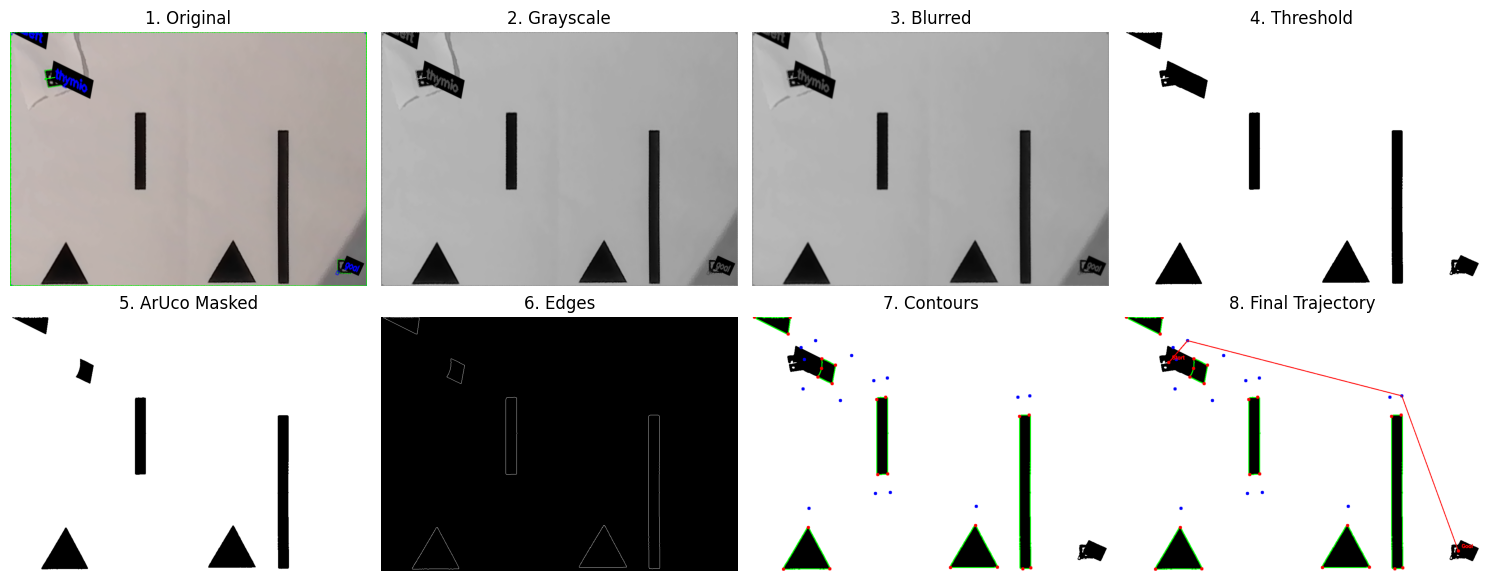

Trajectory found!
Trajectory found!


In [ ]:
# Global variables
got_trajectory = False
trajectory_frame = None
trajectory_pos = None
obstacles_pos = None
thymio_init_pos = None
thymio_init_orientation = None

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        
    print("Getting trajectory...")
    while not got_trajectory:
        original_frame, process_frame, thymio_init_pos, thymio_init_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
        utils.display_frames(original_frame, process_frame, None) 
        if found_thymio and found_goal:
            print("Thymio and goal found!")
            trajectory_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_init_pos, goal_pos)
            print("Trajectory found!")
            ekf.initialize_state(np.array([thymio_init_pos[0], thymio_init_pos[1], thymio_init_orientation, 0.0, 0.0])) # x, y, theta, v, omega
            ekf.set_mode(covered=False) # Start in uncovered mode
            
        time.sleep(dt)
except KeyboardInterrupt:
    display("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.cleanup_webcam()

In [7]:
if got_trajectory:
    obstacles_rounded = {k: np.round(v, 1) for k, v in obstacles_pos.items()}
    obstacles_formatted = '\n '.join([f"{k}: {v}" for k, v in obstacles_rounded.items()])
    print(f"Obstacles [mm]: \n {obstacles_formatted}")

    print(f"Trajectory points [mm]:\n {np.round(trajectory_pos, 1)}")
    print(f"Thymio position [mm]:\n {np.round(thymio_init_pos, 1)}")
    print(f"Thymio orientation [deg]:\n {np.round(np.rad2deg(thymio_init_orientation), 1)}")
    print(f"Goal position [mm]:\n {np.round(trajectory_pos[-1], 1)}")
else:
    display("Could not find a trajectory. Please try again.")
    exit(1)

Obstacles [mm]: 
 obstacle1: [[ 44.7 150.8]
 [ 11.8 205.9]
 [ 73.7 205.8]]
 obstacle2: [[175.8 149.2]
 [142.7 204.6]
 [205.1 204.5]]
 obstacle3: [[217.9  62.6]
 [208.6  63.7]
 [211.8 213. ]
 [219.6 212.2]]
 obstacle4: [[106.2  48.7]
 [ 95.7  50.6]
 [ 96.9 139. ]
 [108.5 138.4]]
 obstacle5: [[50.  19.3]
 [41.2 34.1]
 [40.  57.1]
 [69.3 66.3]
 [78.3 31. ]]
 obstacle6: [[-12.7  -2.8]
 [ 38.5  24.8]
 [ 43.5  -4.8]]
Trajectory points [mm]:
 [[ 35.   36.3]
 [ 50.   19.3]
 [217.9  62.6]
 [262.1 184.1]]
Thymio position [mm]:
 [35.1 36.5]
Thymio orientation [deg]:
 170.60000610351562
Goal position [mm]:
 [262.1 184.1]


In [ ]:
# Global variables
goal_reached = False
background_frame = None
thymio_old_pos = thymio_init_pos
position_measured_history = [] 
position_kalman_history = []   
i = 0
covered = 0
left_speed = 0
right_speed = 0

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
    
    # If this is the first frame, create a copy of trajectory_frame as background
    if trajectory_frame is not None:
        background_frame = trajectory_frame.copy()
        
    while not goal_reached:
        i += 1
        original_frame, process_frame, thymio_pos, thymio_orientation, _, found_thymio, _ = vision.get_frame()
        
        # Predict step - using control inputs
        control_input = np.array([
            scale_speed * (left_speed + right_speed) / 2,  # Linear velocity
            scale_speed * (left_speed - right_speed) / thymio_size['width']  # Angular velocity
        ])
        ekf.predict(control_input, dt)
        
        # Update measurement noise based on camera detection
        ekf.set_mode(covered=not found_thymio)
        
        if found_thymio:  # If thymio is detected
            position_measured_history.append(thymio_pos)
            measurement = np.array([
                thymio_pos[0], 
                thymio_pos[1], 
                thymio_orientation,
                scale_speed * (left_speed + right_speed) / 2,
                scale_speed * (left_speed - right_speed) / thymio_size['width']
            ])
            
            # Update step with measurement
            ekf.update(measurement)
            
            # Get filtered state estimate
            filtered_state = ekf.get_state
            filtered_pos = (filtered_state[0], filtered_state[1])
            filtered_orientation = filtered_state[2]
            
            position_kalman_history.append(filtered_pos)
            
            if utils.distance(thymio_old_pos, filtered_pos) > kidnap_threshold:
                display("KIDNAPPING")
                got_trajectory = False
                motor_stop()
                time.sleep(5)
                while not got_trajectory:
                    original_frame, process_frame, thymio_pos, thymio_orientation, goal_pos, found_thymio, found_goal = vision.get_frame()
                    utils.display_frames(original_frame, process_frame, None)
                    time.sleep(1)
                    if found_thymio and found_goal:
                        up_frame, trajectory_pos, obstacles_pos, got_trajectory = global_nav.get_trajectory(process_frame, thymio_pos, goal_pos)
                        background_frame = up_frame.copy()
                        # Reinitalize local navigation
                        local_nav.current_checkpoint = 0
                        # Reinitialize EKF with new position
                        new_state = np.array([thymio_pos[0], thymio_pos[1], thymio_orientation, 0.0, 0.0])
                        ekf.initialize_state(new_state)
                        display("New Trajectory Found!")
                        time.sleep(1)
                        utils.display_frames(None, None, up_frame)
                        time.sleep(1)
                        
            thymio_old_pos = filtered_pos
        else:
            covered += 1
            # When robot is not visible, use only predicted state
            filtered_state = ekf.get_state
            filtered_pos = (filtered_state[0], filtered_state[1])
            filtered_orientation = filtered_state[2]
            position_kalman_history.append(filtered_pos)
            
        # Use filtered state for navigation
        command, goal_reached = local_nav.navigate(trajectory_pos, filtered_pos, filtered_orientation, sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacle'):
                left_speed = command['left_speed']
                right_speed = command['right_speed']
                motor_move(left_speed, right_speed)
        else:
            motor_stop()

        # Update trajectory frame with robot
        if background_frame is not None:
            current_frame = background_frame.copy()
            # Draw measured trajectory in blue
            trajectory_frame = utils.draw_trajectory(current_frame, position_measured_history, scale_factor, color=(255, 0, 0))
            # Draw filtered trajectory in green
            trajectory_frame = utils.draw_trajectory(trajectory_frame, position_kalman_history, scale_factor, color=(0, 255, 0))
            # Draw robot using filtered position
            trajectory_frame = utils.draw_robot(trajectory_frame, filtered_pos, filtered_orientation, thymio_size, scale_factor)
             # Draw uncertainty ellipse
            covariance = ekf.get_covariance
            trajectory_frame = utils.draw_uncertainty_ellipse(up_frame, filtered_pos, covariance[:2, :2], scale_factor)

        utils.display_frames(original_frame, None, trajectory_frame) 
        time.sleep(dt)
        
except KeyboardInterrupt:
   display("User interrupted the kernel. Closing the webcam...")
finally:
    # Release resources
    vision.cleanup_webcam()
    print("Finished at time [s]:", i * dt)
    print("Camera coverage [%]:", covered/i * 100)
    time.sleep(5)
    utils.display_frames(None, None, trajectory_frame)

'User interrupted the kernel. Closing the webcam...'

Finished at time [s]: 30.200000000000003
Camera coverage [%]: 45.033112582781456


Simulation interrupted
Finished at time [s]: 5.6000000000000005


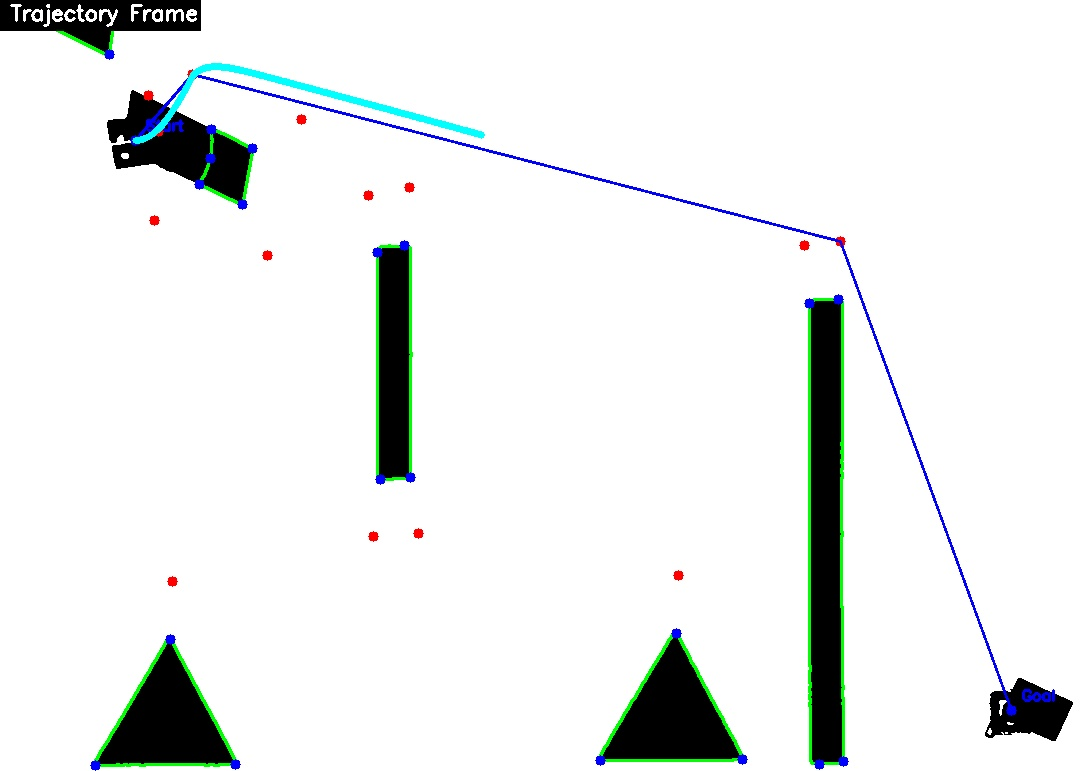

In [8]:
up_frame = trajectory_frame.copy()

def sensor_data():
    return [0, 0, 0, 0, 0, 0, 0, 0]

def update_position(thymio_pos, thymio_orientation, left_speed, right_speed, thymio_width, dt):
    # Convert speeds to velocities
    linear_velocity = (left_speed + right_speed) / 2  
    angular_velocity = (left_speed - right_speed) / thymio_width
    
    # Update orientation and position
    thymio_orientation += angular_velocity * dt
    delta_x = linear_velocity * np.cos(thymio_orientation) * dt
    delta_y = linear_velocity * np.sin(thymio_orientation) * dt
    
    new_pos = (thymio_pos[0] + delta_x, thymio_pos[1] + delta_y)
    
    return new_pos, thymio_orientation

goal_reached = False
thymio_pos = thymio_init_pos
thymio_orientation = 0
position_measured_history = []
position_estimated_history = []  # Add history for EKF estimates
i = 0
left_speed = 0 
right_speed = 0

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        if up_frame is not None:
            background_frame = up_frame.copy()
        
        while not goal_reached:
            i += 1
            
            # Get control input for EKF
            linear_velocity = (left_speed + right_speed) / 2
            angular_velocity = (left_speed - right_speed) / thymio_size['width']
            control_input = np.array([linear_velocity, angular_velocity])
            
            # EKF Prediction step
            ekf.predict(control_input, dt)
            
            # Get vision measurement (simulated here - replace with actual vision data)
            vision_measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_orientation, linear_velocity, angular_velocity])
            
            # EKF Update step
            ekf.update(vision_measurement)
            
            # Get estimated state from EKF
            estimated_state = ekf.get_state
            estimated_pos = np.array([estimated_state[0], estimated_state[1]])
            estimated_orientation = estimated_state[2]
            
            # Store histories
            position_measured_history.append(thymio_pos)
            position_estimated_history.append(estimated_pos)
            
            # Use EKF estimated position for navigation
            command, goal_reached = local_nav.get_command(
                trajectory_pos, 
                estimated_pos,  # Use EKF estimate instead of raw position
                estimated_orientation,  # Use EKF estimate
                sensor_data()
            )
            
            if command['action'] in ['follow_path', 'avoid_obstacle']:
                left_speed = command['left_speed'] 
                right_speed = command['right_speed']
            else:
                left_speed = 0
                right_speed = 0
            
            # Update position through simulation
            new_pos, thymio_orientation = update_position(
                thymio_pos, 
                thymio_orientation,
                left_speed, 
                right_speed,
                thymio_size['width'],
                dt
            )
            thymio_pos = np.array(new_pos)
            
            # Update trajectory frame with robot
            if background_frame is not None:
                current_frame = background_frame.copy()
                # Draw measured trajectory in one color
                up_frame = utils.draw_trajectory(current_frame, position_measured_history, scale_factor, color=(0, 255, 255), )
                # Draw estimated trajectory in different color
                up_frame = utils.draw_trajectory(up_frame, position_estimated_history, scale_factor, color=(255, 255, 0))
                # Draw robot using estimated position
                up_frame = utils.draw_robot(up_frame, estimated_pos, estimated_orientation, thymio_size, scale_factor)
                # Draw uncertainty ellipse
                covariance = ekf.get_covariance
                up_frame = utils.draw_uncertainty_ellipse(up_frame, estimated_pos, covariance[:2, :2], scale_factor)
                
                utils.display_frames(None, None, up_frame)
            
            time.sleep(dt)
            
except KeyboardInterrupt:
    local_nav.current_checkpoint = 0
    print("Simulation interrupted")
finally:
    vision.cleanup_webcam()
    local_nav.current_checkpoint = 0
    print("Finished at time [s]:", i * dt)
    utils.display_frames(None, None, up_frame)


In [20]:
await tdmclient.notebook.stop()